In [29]:
import itertools
import pandas as pd
import numpy as np
import random
import csv
import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import keras.backend as K
from keras import Sequential
from keras.layers import Dense, Dropout

from collections import OrderedDict

In [39]:
datapath = '~/aiffel/RL_Recommender/books_3000.csv'
datapath_org = '~/aiffel/RL_Recommender/Books.csv'
df = pd.read_csv(datapath)

In [40]:
df.head()

,item,user,rating,timestamp
0,13,4,5.0,982972800
1,29,13,4.0,1054166400
2,29,4,4.0,1053216000
3,10,12,2.0,1410134400
4,10,6,5.0,1387670400


In [41]:
df.sort_values(by='user')

,item,user,rating,timestamp
45948,57274,0,5.0,1336262400
85900,66350,0,5.0,1319587200
85899,66354,0,5.0,1318550400
85896,66344,0,1.0,1369180800
59565,81131,0,5.0,1298160000
...,...,...,...,...
3791,2882,21,2.0,1057622400
8101,7167,21,5.0,1273968000
1309,674,21,4.0,1406419200
56504,74293,21,4.0,1471478400


In [42]:
user_counts = pd.DataFrame(df['user'].value_counts())
user_counts

,user
14,9684
13,9074
18,7077
21,5842
8,4437
15,4342
4,4160
2,4159
16,4134
17,3960


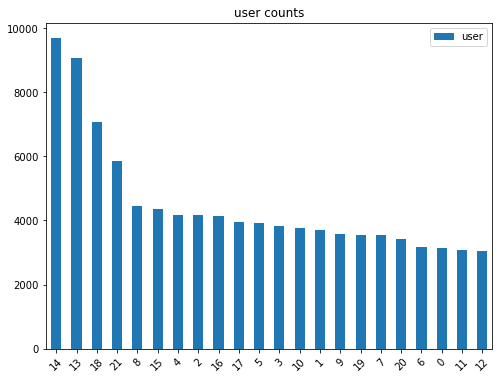

In [43]:
user_counts.plot(kind='bar',title = 'user counts',
 rot=45, fontsize=10, figsize=(8, 6))

In [44]:
user_14 = df[df['user']== 14]
user_14

,item,user,rating,timestamp
16,40,14,5.0,1280188800
197,43,14,5.0,1357603200
198,43,14,5.0,1357603200
309,126,14,5.0,1357776000
310,126,14,5.0,1357776000
...,...,...,...,...
98583,83352,14,5.0,1343260800
98584,83354,14,5.0,1503360000
98585,83355,14,5.0,1485043200
98587,83356,14,5.0,1504483200


In [66]:
user_14_item_count = pd.DataFrame(user_14['item'].value_counts())

In [72]:
user_14_item_count

,item
22530,19
82225,19
8729,14
21791,14
2716,13
...,...
76088,1
41273,1
65853,1
41281,1


In [67]:
user_14_item_count[user_14_item_count['item'] != 1] # 1번만 산 아이템 제외

,item
22530,19
82225,19
8729,14
21791,14
2716,13
...,...
48168,2
26516,2
45278,2
39587,2


In [76]:
user_14_item_count[user_14_item_count['item'] >5] # 5번 이상 산 아이템

,item
22530,19
82225,19
8729,14
21791,14
2716,13
...,...
30905,6
27409,6
29147,6
72997,6


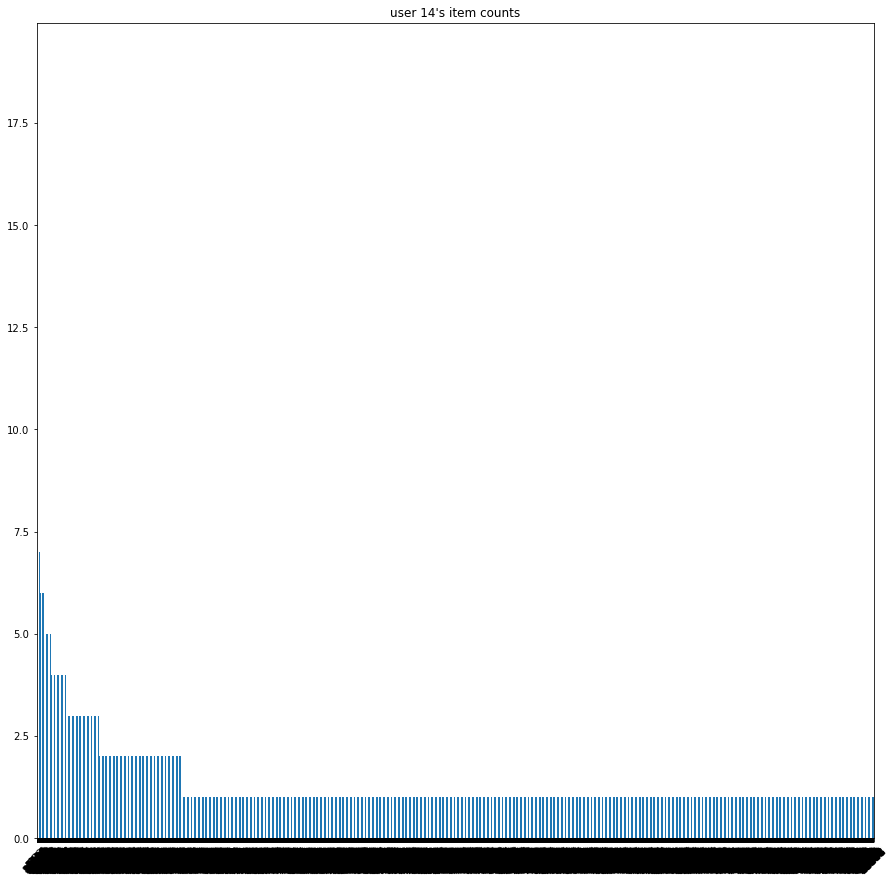

In [46]:
user_14['item'].value_counts().plot(kind='bar',title = 'user 14\'s item counts',
 rot=45, fontsize=10, figsize=(15, 15))

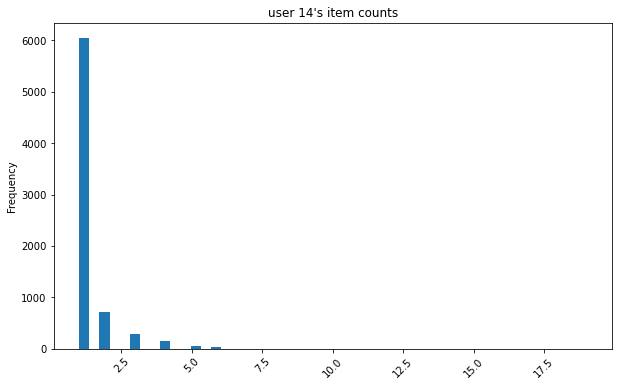

In [70]:
user_14['item'].value_counts().plot(kind='hist',title = 'user 14\'s item counts',
 rot=45, fontsize=10, figsize=(10, 6), bins=50)

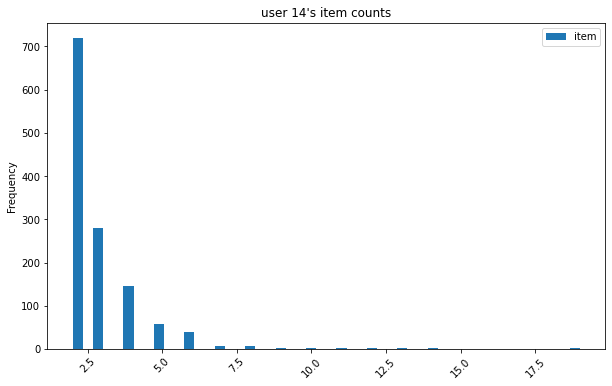

In [71]:
user_14_item_count[user_14_item_count['item'] != 1].plot(kind='hist',title = 'user 14\'s item counts',
 rot=45, fontsize=10, figsize=(10, 6), bins=50)

# json 파일 parsing - Metadata

In [1]:
import json # import json module

json_list = []
# with statement
# with open('../aiffel/RL_Recommender/meta_Books.json') as json_file:
#     metadata = json.load(json_file)

for line in open('../aiffel/RL_Recommender/meta_Books.json'):
    json_list.append(json.loads(line))

In [4]:
df_md = pd.DataFrame(json_list) # dataframe for metadata

In [5]:
df_md_copy = df_md.copy() # 복사본 만들기....ㅠㅠ 오류터질때마다 매번 다시 불러오기 오래걸려서..

In [19]:
df_md = df_md_copy.copy() # 저장한거 불러올때 쓰삼~

In [24]:
'New, Used & Rental Textbooks' in df_md['category'][1]

False

In [ ]:
for i in range(len(df_md['category'])):
    if 'New, Used & Rental Textbooks' in df_md['category'][i] or 'New, Used &amp; Rental Textbooks' in df_md['category'][i]:
        print(df_md['category'][i])

In [19]:
df_md

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,details
0,[],,[It is a biology book with God&apos;s perspect...,,Biology Gods Living Creation Third Edition 10 ...,"[0669009075, B000K2P5SA, B00MD4G2N0, B000ASIPT...",[],,Keith Graham,[],"1,349,781 in Books (","[0019777701, B000AUCX7I, B000K2P5SA, B001CK63X...",Books,,,$39.94,0000092878,NaN
1,"[Books, New, Used & Rental Textbooks, Medicine...",,[],,Mksap 16 Audio Companion: Medical Knowledge Se...,[],[],,Acp,[],"1,702,625 in Books (","[B01MUCYEV7, B01KUGTY6O]",Books,,,,000047715X,NaN
2,"[Books, Arts & Photography, Music]",,"[Discography of American Punk, Hardcore, and P...",,"Flex! Discography of North American Punk, Hard...",[],[],,Burkhard Jarisch,[],"6,291,012 in Books (",[],Books,,,$199.99,0000004545,NaN
3,"[Books, Arts & Photography, Music]",,[This is a collection of classic gospel hymns ...,,Heavenly Highway Hymns: Shaped-Note Hymnal,[],[],,Stamps/Baxter,[],"2,384,057 in Books (","[0006180116, 0996092730, B000QFOGY0, B06WWKNDL...",Books,,,,0000013765,NaN
4,[],,[],,Georgina Goodman Nelson Womens Size 8.5 Purple...,[],[],,,[],"11,735,726 in Books (",[],Books,,,$164.10,0000000116,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934944,"[Books, Mystery, Thriller & Suspense, Thriller...",,[],,Made Men: A Thriller (Law of Retaliation Book ...,[B01CRJ3J1I],[],,Visit Amazon's Bradley Ernst Page,[],"1,436,585 Paid in Kindle Store (",[],Buy a Kindle,,,,B01HJBPTUI,"{'File Size:': '1963 KB', 'Print Length:': '27..."
2934945,"[Books, Literature & Fiction, Erotica]",,[],,Raptor&#39;s Desire (A Planet Desire novelette...,"[B01CWFQJKU, B01G7W20HA, B01CXJDC0U, B01H3XUPV...",[],,Visit Amazon's Delilah Devlin Page,[],"1,060,621 Paid in Kindle Store (",[],Buy a Kindle,,,,B01HJC63ZM,"{'File Size:': '1903 KB', 'Print Length:': '50..."
2934946,[],,[],,"LG K4 Case,LG Optimus Zone 3 Case,LG Spree Cas...",[],[],,,[],[],[],Books,,,,B01HJEB422,{'Publisher:': 'Veggzy is a young and dynamic ...
2934947,"[Books, Religion & Spirituality, New Age & Spi...",,[],,Magickal Incantations,"[B06XP26WK7, B0797Y6JH6, B01M72TG0D, B00JCFEMB...",[],,SilvrMyst,[],"645,067 Paid in Kindle Store (",[],Buy a Kindle,,,,B01HJDS76Y,"{'File Size:': '164 KB', 'Print Length:': '10 ..."


In [5]:
for i in range(len(df_md['category'])):
    if len(df_md['category'][i]) < 1:
        pass
    else:
        df_md['category'][i] = df_md['category'][i][-1]
        if i%100000 == 0:
            print(i, ' completed')

100000  completed
200000  completed


KeyboardInterrupt: 

In [12]:
def cat_preprocess(i):
    if len(i)<1:
        pass
    else:
        i = i[-1]
        print(i)
    

In [21]:
start = time.time()
# 카테고리 처리 코드
for i in range(len(df_md['category'])):
    if len(df_md['category'][i]) < 1:
        pass
    elif df_md['category'][i][-2] == 'New, Used &amp; Rental Textbooks' or 
    df_md['category'][i][-2] == 'New, Used & Rental Textbooks' or 
    df_md['category'][i][0] == 'New, Used &amp; Rental Textbooks' or 
    df_md['category'][i][0] == 'New, Used & Rental Textbooks' or
    df_md['category'][i][-2] == 'Books':
        df_md.at[i, 'category'] = df_md['category'][i][-1]
    
    else:
        val = df_md['category'][i][-2]
        df_md.at[i, 'category'] = val
    if i%100000 == 0:
        print(i, ' completed')
        

print("time :", time.time() - start)

0  completed
100000  completed
200000  completed
300000  completed
400000  completed
500000  completed
600000  completed
700000  completed
800000  completed
900000  completed
1000000  completed
1100000  completed
1200000  completed
1300000  completed
1400000  completed
1500000  completed
1600000  completed
1700000  completed
1800000  completed
1900000  completed
2000000  completed
2100000  completed
2200000  completed
2300000  completed
2400000  completed
2500000  completed
2600000  completed
2700000  completed
2800000  completed
2900000  completed
time : 233.8112485408783


In [23]:
cat_updated_copy = df_md.copy() # 작업된거 다시 복사!

In [28]:
df_md = cat_updated_copy.copy() # 복사한거 불러오기

In [29]:
df_md # 데이터 다시확인

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,details
0,[],,[It is a biology book with God&apos;s perspect...,,Biology Gods Living Creation Third Edition 10 ...,"[0669009075, B000K2P5SA, B00MD4G2N0, B000ASIPT...",[],,Keith Graham,[],"1,349,781 in Books (","[0019777701, B000AUCX7I, B000K2P5SA, B001CK63X...",Books,,,$39.94,0000092878,NaN
1,Medicine & Health Sciences,,[],,Mksap 16 Audio Companion: Medical Knowledge Se...,[],[],,Acp,[],"1,702,625 in Books (","[B01MUCYEV7, B01KUGTY6O]",Books,,,,000047715X,NaN
2,Arts & Photography,,"[Discography of American Punk, Hardcore, and P...",,"Flex! Discography of North American Punk, Hard...",[],[],,Burkhard Jarisch,[],"6,291,012 in Books (",[],Books,,,$199.99,0000004545,NaN
3,Arts & Photography,,[This is a collection of classic gospel hymns ...,,Heavenly Highway Hymns: Shaped-Note Hymnal,[],[],,Stamps/Baxter,[],"2,384,057 in Books (","[0006180116, 0996092730, B000QFOGY0, B06WWKNDL...",Books,,,,0000013765,NaN
4,[],,[],,Georgina Goodman Nelson Womens Size 8.5 Purple...,[],[],,,[],"11,735,726 in Books (",[],Books,,,$164.10,0000000116,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934944,"Mystery, Thriller & Suspense",,[],,Made Men: A Thriller (Law of Retaliation Book ...,[B01CRJ3J1I],[],,Visit Amazon's Bradley Ernst Page,[],"1,436,585 Paid in Kindle Store (",[],Buy a Kindle,,,,B01HJBPTUI,"{'File Size:': '1963 KB', 'Print Length:': '27..."
2934945,Literature & Fiction,,[],,Raptor&#39;s Desire (A Planet Desire novelette...,"[B01CWFQJKU, B01G7W20HA, B01CXJDC0U, B01H3XUPV...",[],,Visit Amazon's Delilah Devlin Page,[],"1,060,621 Paid in Kindle Store (",[],Buy a Kindle,,,,B01HJC63ZM,"{'File Size:': '1903 KB', 'Print Length:': '50..."
2934946,[],,[],,"LG K4 Case,LG Optimus Zone 3 Case,LG Spree Cas...",[],[],,,[],[],[],Books,,,,B01HJEB422,{'Publisher:': 'Veggzy is a young and dynamic ...
2934947,Religion & Spirituality,,[],,Magickal Incantations,"[B06XP26WK7, B0797Y6JH6, B01M72TG0D, B00JCFEMB...",[],,SilvrMyst,[],"645,067 Paid in Kindle Store (",[],Buy a Kindle,,,,B01HJDS76Y,"{'File Size:': '164 KB', 'Print Length:': '10 ..."


In [30]:
df_md['category'].value_counts().head(50)

[]                                  389429
Literature &amp; Fiction            245054
Children's Books                    240944
History                             138048
Literature & Fiction                109725
Arts &amp; Photography              107974
Christian Books &amp; Bibles        107703
Reference                            69581
Biographies &amp; Memoirs            67130
Crafts, Hobbies &amp; Home           65446
Business &amp; Money                 64092
Romance                              58542
Humanities                           58409
Religion &amp; Spirituality          54353
Self-Help                            53504
Mystery, Thriller &amp; Suspense     53000
Arts & Photography                   49568
Politics &amp; Social Sciences       48902
Travel                               48673
Science &amp; Math                   45800
Science Fiction &amp; Fantasy        44434
Christian Books & Bibles             42340
Computers &amp; Technology           38632
Cookbooks, 

In [31]:
df_md['category'] = df_md['category'].str.replace(' &amp; ',' & ', regex=True)

In [42]:
df_md['category'].value_counts() # 성공!!

Literature & Fiction        354779
Children's Books            240944
Arts & Photography          157542
Christian Books & Bibles    150043
History                     138048
                             ...  
Diabetes                         1
ISBN: 9781285176963              1
Commentaries                     1
Agricultural Sciences            1
Woodworking                      1
Name: category, Length: 437, dtype: int64

In [36]:
df_md['category'].value_counts().nunique() # 유니크 카테고리 수가 확실히 줄었따!

96

In [43]:
df_md.to_csv('~/aiffel/RL_Recommender/meta_category_updated.csv')

### Category와 item id (asin)만 따오기

In [ ]:
df_md = pd.read_csv('~/aiffel/RL_Recommender/meta_category_updated.csv')

In [20]:
df_md

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,details
0,[],NaN,['It is a biology book with God&apos;s perspec...,NaN,Biology Gods Living Creation Third Edition 10 ...,"['0669009075', 'B000K2P5SA', 'B00MD4G2N0', 'B0...",[],NaN,Keith Graham,[],"1,349,781 in Books (","['0019777701', 'B000AUCX7I', 'B000K2P5SA', 'B0...",Books,NaN,NaN,$39.94,0000092878,NaN
1,Medicine & Health Sciences,NaN,[],NaN,Mksap 16 Audio Companion: Medical Knowledge Se...,[],[],NaN,Acp,[],"1,702,625 in Books (","['B01MUCYEV7', 'B01KUGTY6O']",Books,NaN,NaN,NaN,000047715X,NaN
2,Music,NaN,"['Discography of American Punk, Hardcore, and ...",NaN,"Flex! Discography of North American Punk, Hard...",[],[],NaN,Burkhard Jarisch,[],"6,291,012 in Books (",[],Books,NaN,NaN,$199.99,0000004545,NaN
3,Music,NaN,['This is a collection of classic gospel hymns...,NaN,Heavenly Highway Hymns: Shaped-Note Hymnal,[],[],NaN,Stamps/Baxter,[],"2,384,057 in Books (","['0006180116', '0996092730', 'B000QFOGY0', 'B0...",Books,NaN,NaN,NaN,0000013765,NaN
4,[],NaN,[],NaN,Georgina Goodman Nelson Womens Size 8.5 Purple...,[],[],NaN,NaN,[],"11,735,726 in Books (",[],Books,NaN,NaN,$164.10,0000000116,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934944,Thrillers & Suspense,NaN,[],NaN,Made Men: A Thriller (Law of Retaliation Book ...,['B01CRJ3J1I'],[],NaN,Visit Amazon's Bradley Ernst Page,[],"1,436,585 Paid in Kindle Store (",[],Buy a Kindle,NaN,NaN,NaN,B01HJBPTUI,"{'File Size:': '1963 KB', 'Print Length:': '27..."
2934945,Erotica,NaN,[],NaN,Raptor&#39;s Desire (A Planet Desire novelette...,"['B01CWFQJKU', 'B01G7W20HA', 'B01CXJDC0U', 'B0...",[],NaN,Visit Amazon's Delilah Devlin Page,[],"1,060,621 Paid in Kindle Store (",[],Buy a Kindle,NaN,NaN,NaN,B01HJC63ZM,"{'File Size:': '1903 KB', 'Print Length:': '50..."
2934946,[],NaN,[],NaN,"LG K4 Case,LG Optimus Zone 3 Case,LG Spree Cas...",[],[],NaN,NaN,[],[],[],Books,NaN,NaN,NaN,B01HJEB422,{'Publisher:': 'Veggzy is a young and dynamic ...
2934947,New Age & Spirituality,NaN,[],NaN,Magickal Incantations,"['B06XP26WK7', 'B0797Y6JH6', 'B01M72TG0D', 'B0...",[],NaN,SilvrMyst,[],"645,067 Paid in Kindle Store (",[],Buy a Kindle,NaN,NaN,NaN,B01HJDS76Y,"{'File Size:': '164 KB', 'Print Length:': '10 ..."


In [12]:
df_md_new = df_md.loc[:, ['category', 'asin']]

In [13]:
df_md_new

,category,asin
0,[],0000092878
1,Medicine & Health Sciences,000047715X
2,Music,0000004545
3,Music,0000013765
4,[],0000000116
...,...,...
2934944,Thrillers & Suspense,B01HJBPTUI
2934945,Erotica,B01HJC63ZM
2934946,[],B01HJEB422
2934947,New Age & Spirituality,B01HJDS76Y


In [12]:
df_md_new.rename(columns = {'asin':'item'}, inplace = True)

In [3]:
df_md_new

,category,item
0,[],0000092878
1,Medicine & Health Sciences,000047715X
2,Music,0000004545
3,Music,0000013765
4,[],0000000116
...,...,...
2934944,Thrillers & Suspense,B01HJBPTUI
2934945,Erotica,B01HJC63ZM
2934946,[],B01HJEB422
2934947,New Age & Spirituality,B01HJDS76Y


In [10]:
df_md_new.duplicated().value_counts()

False    2930024
True        4925
dtype: int64

In [17]:
pd.set_option('display.max_rows', 100)
ids = df_md_new["item"]
df_md_new[ids.isin(ids[ids.duplicated()])].sort_values("item").head(100)

,category,item
2603424,[],B00000IJYC
2608349,[],B00000IJYC
2603426,[],B00000IJYX
2608351,[],B00000IJYX
2608350,[],B00000IJZO
2603425,[],B00000IJZO
2603428,[],B00000IRGQ
2608353,[],B00000IRGQ
2603427,[],B00000IRGX
2608352,[],B00000IRGX


In [8]:
df_md_new['item'].nunique()

2930024

In [58]:
df_md_new['category'].nunique()

1252

In [14]:
df_md_new.to_csv('~/aiffel/RL_Recommender/meta_category+item.csv', index=False)

In [2]:
df_md_new = pd.read_csv('~/aiffel/RL_Recommender/meta_category+item.csv')

### title 붙히기

In [45]:
df_md_CaItTi = df_md.loc[:, ['category', 'title', 'asin']]

In [46]:
df_md_CaItTi.rename(columns = {'asin':'item'}, inplace = True)

In [47]:
df_md_CaItTi

,category,title,item
0,NaN,Biology Gods Living Creation Third Edition 10 ...,0000092878
1,Medicine & Health Sciences,Mksap 16 Audio Companion: Medical Knowledge Se...,000047715X
2,Arts & Photography,"Flex! Discography of North American Punk, Hard...",0000004545
3,Arts & Photography,Heavenly Highway Hymns: Shaped-Note Hymnal,0000013765
4,NaN,Georgina Goodman Nelson Womens Size 8.5 Purple...,0000000116
...,...,...,...
2934944,"Mystery, Thriller & Suspense",Made Men: A Thriller (Law of Retaliation Book ...,B01HJBPTUI
2934945,Literature & Fiction,Raptor&#39;s Desire (A Planet Desire novelette...,B01HJC63ZM
2934946,NaN,"LG K4 Case,LG Optimus Zone 3 Case,LG Spree Cas...",B01HJEB422
2934947,Religion & Spirituality,Magickal Incantations,B01HJDS76Y


In [41]:
df_md_CaItTi['title'][2934946] # 메타 데이터에 책이 아닌것도 있다.

'LG K4 Case,LG Optimus Zone 3 Case,LG Spree Case,LG Rebel LTE Case,Veggzy[Kickstand]Slim Heavy Duty Shock Absorption Rugged Armor Dual Layer Hybird High Impact Resistant Defender Protective Hard Cover'

In [48]:
df_md_CaItTi.duplicated().value_counts()

False    2930024
True        4925
dtype: int64

In [49]:
ids = df_md_CaItTi["item"]
df_md_CaItTi[ids.isin(ids[ids.duplicated()])].sort_values("item")

,category,title,item
2603424,NaN,Adventure Journal,B00000IJYC
2608349,NaN,Adventure Journal,B00000IJYC
2603426,NaN,Tiffany Windows Note Cards,B00000IJYX
2608351,NaN,Tiffany Windows Note Cards,B00000IJYX
2608350,NaN,NiteOwl DC Plus Upgrade Kit,B00000IJZO
...,...,...,...
2608346,"Cookbooks, Food & Wine",Reco Complete Guide to Clay Pot Cooking Cookbook,B0003UEOM2
2608348,Arts & Photography,Carl Fischer Arbans Complete Method-Trumpet,B0004372Q8
2613273,Arts & Photography,Carl Fischer Arbans Complete Method-Trumpet,B0004372Q8
2608347,NaN,Flowering Judas,B000449040


In [50]:
df_md_CaItTi.drop_duplicates(inplace = True)
df_md_CaItTi

,category,title,item
0,NaN,Biology Gods Living Creation Third Edition 10 ...,0000092878
1,Medicine & Health Sciences,Mksap 16 Audio Companion: Medical Knowledge Se...,000047715X
2,Arts & Photography,"Flex! Discography of North American Punk, Hard...",0000004545
3,Arts & Photography,Heavenly Highway Hymns: Shaped-Note Hymnal,0000013765
4,NaN,Georgina Goodman Nelson Womens Size 8.5 Purple...,0000000116
...,...,...,...
2934944,"Mystery, Thriller & Suspense",Made Men: A Thriller (Law of Retaliation Book ...,B01HJBPTUI
2934945,Literature & Fiction,Raptor&#39;s Desire (A Planet Desire novelette...,B01HJC63ZM
2934946,NaN,"LG K4 Case,LG Optimus Zone 3 Case,LG Spree Cas...",B01HJEB422
2934947,Religion & Spirituality,Magickal Incantations,B01HJDS76Y


In [3]:
ids = df_md_CaItTi["item"]
df_md_CaItTi[ids.isin(ids[ids.duplicated()])].sort_values("item")

,category,title,item


In [52]:
df_md_CaItTi.duplicated().value_counts()

False    2930024
dtype: int64

In [53]:
df_md_CaItTi.to_csv('~/aiffel/RL_Recommender/meta_category+item+title.csv', index=False)

In [3]:
df_md_CaItTi = pd.read_csv('~/aiffel/RL_Recommender/meta_category+item+title.csv')

### 유니크 카테고리 보기

In [20]:
df_md_CaItTi['category'].nunique() # 1252개

1252

# 합치기

## 제일 많은 유저 기준

In [4]:
df_orig = pd.read_csv('~/aiffel/RL_Recommender/Books.csv', names=['item','user','rating','timestamp'])

In [5]:
df_orig

,item,user,rating,timestamp
0,0001713353,A1C6M8LCIX4M6M,5.0,1123804800
1,0001713353,A1REUF3A1YCPHM,5.0,1112140800
2,0001713353,A1YRBRK2XM5D5,5.0,1081036800
3,0001713353,A1V8ZR5P78P4ZU,5.0,1077321600
4,0001713353,A2ZB06582NXCIV,5.0,1475452800
...,...,...,...,...
51311616,B01HJDS76Y,A3P8PUZFHWFK1E,4.0,1467244800
51311617,B01HJDS76Y,A26Q9T9G9MTX9S,1.0,1467158400
51311618,B01HJEB422,AB9M1MQPBAS2J,5.0,1487030400
51311619,B01HJEB422,A2TO93KMH3DJIK,5.0,1485648000


In [6]:
user_counts = pd.DataFrame(df_orig['user'].value_counts())
user_counts = user_counts[user_counts['user'] >9000]

In [7]:
user_counts

,user
A2OJW07GQRNJUT,9684
A2F6N60Z96CAJI,9074


In [5]:
mx_rt_user = df_orig[df_orig['user'] == 'A2OJW07GQRNJUT'] # 제일 rating을 많이 한 유저

In [9]:
mx_rt_user

,item,user,rating,timestamp
6423,0002152525,A2OJW07GQRNJUT,5.0,1280188800
52690,0002160552,A2OJW07GQRNJUT,5.0,1357603200
52691,0002160552,A2OJW07GQRNJUT,5.0,1357603200
100578,0006211712,A2OJW07GQRNJUT,5.0,1357776000
100589,0006211712,A2OJW07GQRNJUT,5.0,1357776000
...,...,...,...,...
51298702,B01FJ0W2I8,A2OJW07GQRNJUT,5.0,1343260800
51299284,B01FKTCBY8,A2OJW07GQRNJUT,5.0,1503360000
51299407,B01FKTOQKK,A2OJW07GQRNJUT,5.0,1485043200
51299536,B01FKUTST8,A2OJW07GQRNJUT,5.0,1504483200


In [6]:
mxusr_merged = pd.merge(mx_rt_user,df_md_CaItTi, how='left')
mxusr_merged

,item,user,rating,timestamp,category,title
0,0002152525,A2OJW07GQRNJUT,5.0,1280188800,Religion & Spirituality,Future of Man
1,0002160552,A2OJW07GQRNJUT,5.0,1357603200,History,Freedom at midnight
2,0002160552,A2OJW07GQRNJUT,5.0,1357603200,History,Freedom at midnight
3,0006211712,A2OJW07GQRNJUT,5.0,1357776000,Biographies & Memoirs,Surprised by Joy
4,0006211712,A2OJW07GQRNJUT,5.0,1357776000,Biographies & Memoirs,Surprised by Joy
...,...,...,...,...,...,...
9679,B01FJ0W2I8,A2OJW07GQRNJUT,5.0,1343260800,NaN,Hans Kung (Makers of the Modern Theological Mi...
9680,B01FKTCBY8,A2OJW07GQRNJUT,5.0,1503360000,NaN,Black Theology and Black Power by James H. Con...
9681,B01FKTOQKK,A2OJW07GQRNJUT,5.0,1485043200,NaN,"Hartshorne, Process Philosophy, and Theology b..."
9682,B01FKUTST8,A2OJW07GQRNJUT,5.0,1504483200,NaN,Vanishing Boundaries: The Religion of Mainline...


In [20]:
df_merge_outer = pd.merge(df_orig,df_md_CaItTi, how='outer',on='item')
df_merge_outer

,item,user,rating,timestamp,category,title
0,0001713353,A1C6M8LCIX4M6M,5.0,1.123805e+09,Children's Books,"King, the Mice and the Cheese (Beginner Books)"
1,0001713353,A1REUF3A1YCPHM,5.0,1.112141e+09,Children's Books,"King, the Mice and the Cheese (Beginner Books)"
2,0001713353,A1YRBRK2XM5D5,5.0,1.081037e+09,Children's Books,"King, the Mice and the Cheese (Beginner Books)"
3,0001713353,A1V8ZR5P78P4ZU,5.0,1.077322e+09,Children's Books,"King, the Mice and the Cheese (Beginner Books)"
4,0001713353,A2ZB06582NXCIV,5.0,1.475453e+09,Children's Books,"King, the Mice and the Cheese (Beginner Books)"
...,...,...,...,...,...,...
51311765,B001GBTHQU,NaN,NaN,NaN,NaN,The Military Advisor - the Publication for Int...
51311766,B001KJCQPC,NaN,NaN,NaN,NaN,"Books"" />"
51311767,B002E0TKO6,NaN,NaN,NaN,Romance,Not Another Bad Date {Unabridged} {Audio} {Cd}
51311768,B00GSD9J8C,NaN,NaN,NaN,NaN,Union of Dzogchen and Bodhichitta: A Guide to ...


In [8]:
print(51311621 - 51311770, '만큼 차이난다!')

-149 만큼 차이난다!


In [15]:
df_merge_outer.isna().sum() # 걔들은 여기서 나온거

item               0
user             149
rating           149
timestamp        149
category     2634100
title          12790
dtype: int64

In [16]:
df_merge_outer[df_merge_outer['user'].isnull()] # 149개의 user 컬럼 NaN 데이터

,item,user,rating,timestamp,category,title
51311621,0002006553,NaN,NaN,NaN,NaN,Silverwing
51311622,002732530X,NaN,NaN,NaN,Children's Books,White Snow / Blue Feather
51311623,0070509603,NaN,NaN,NaN,Science & Math,Solutions Manual to Accompany Electricity and ...
51311624,0071496955,NaN,NaN,NaN,Social Sciences,Teach Yourself Marx (Teach Yourself: General R...
51311625,012784578X,NaN,NaN,NaN,Medicine & Health Sciences,SEATING AND MOBILITY: For Persons with Physica...
...,...,...,...,...,...,...
51311765,B001GBTHQU,NaN,NaN,NaN,NaN,The Military Advisor - the Publication for Int...
51311766,B001KJCQPC,NaN,NaN,NaN,NaN,"Books"" />"
51311767,B002E0TKO6,NaN,NaN,NaN,Romance,Not Another Bad Date {Unabridged} {Audio} {Cd}
51311768,B00GSD9J8C,NaN,NaN,NaN,NaN,Union of Dzogchen and Bodhichitta: A Guide to ...


In [17]:
df_merge_outer.dropna(subset=['user'], inplace = True) # 데이터 수가 정확히 일치
df_merge_outer

,item,user,rating,timestamp,category,title
0,0001713353,A1C6M8LCIX4M6M,5.0,1.123805e+09,Children's Books,"King, the Mice and the Cheese (Beginner Books)"
1,0001713353,A1REUF3A1YCPHM,5.0,1.112141e+09,Children's Books,"King, the Mice and the Cheese (Beginner Books)"
2,0001713353,A1YRBRK2XM5D5,5.0,1.081037e+09,Children's Books,"King, the Mice and the Cheese (Beginner Books)"
3,0001713353,A1V8ZR5P78P4ZU,5.0,1.077322e+09,Children's Books,"King, the Mice and the Cheese (Beginner Books)"
4,0001713353,A2ZB06582NXCIV,5.0,1.475453e+09,Children's Books,"King, the Mice and the Cheese (Beginner Books)"
...,...,...,...,...,...,...
51311616,B01HJDS76Y,A3P8PUZFHWFK1E,4.0,1.467245e+09,Religion & Spirituality,Magickal Incantations
51311617,B01HJDS76Y,A26Q9T9G9MTX9S,1.0,1.467158e+09,Religion & Spirituality,Magickal Incantations
51311618,B01HJEB422,AB9M1MQPBAS2J,5.0,1.487030e+09,NaN,"LG K4 Case,LG Optimus Zone 3 Case,LG Spree Cas..."
51311619,B01HJEB422,A2TO93KMH3DJIK,5.0,1.485648e+09,NaN,"LG K4 Case,LG Optimus Zone 3 Case,LG Spree Cas..."


In [18]:
print(51311621 - 51311621, '만큼 차이난다!')

0 만큼 차이난다!


In [1]:
df_merge_outer.to_csv('~/aiffel/RL_Recommender/book+category+title.csv', index=False)

NameError: name 'df_merge_outer' is not defined

# Plot

### 제일 rating을 많이 한 유저(A2OJW07GQRNJUT)의 시간별 카테고리 변화

In [115]:
mxusr_count = pd.DataFrame(mxusr_merged['timestamp'].value_counts())
mxusr_count = mxusr_count[mxusr_count['timestamp']>27] # 그냥 n개 기준으로 했다.
mxusr_count.reset_index(inplace = True)
mxusr_count

,index,timestamp
0,1374710400,48
1,1374796800,37
2,1378425600,37
3,1382486400,35
4,1374537600,33
5,1376438400,33
6,1389052800,31
7,1369872000,28


In [116]:
mxusr_cat_count_time = mxusr_merged[mxusr_merged['timestamp'] == mxusr_count.iloc[0][0]]
b = mxusr_cat_count_time.groupby('timestamp').apply(lambda x: x['category'].value_counts(normalize = True))

for i in range(1, len(mxusr_count)):
    mxusr_cat_count_time = mxusr_merged[mxusr_merged['timestamp'] == mxusr_count.iloc[i][0]]
    b = b.append(mxusr_cat_count_time.groupby('timestamp').apply(lambda x: x['category'].value_counts(normalize = True)))

    b = b.sort_index(axis = 0)
b

,Biographies & Memoirs,Christian Books & Bibles,"Health, Fitness & Dieting",History,Humanities,Literature & Fiction,Medical Books,"New, Used & Rental Textbooks",Politics & Social Sciences,Reference,Religion & Spirituality,Science & Math,Self-Help,Social Sciences
timestamp,,,,,,,,,,,,,,
1369872000,NaN,NaN,0.291667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.541667,0.166667
1374537600,0.030303,0.484848,NaN,0.333333,NaN,0.030303,NaN,NaN,NaN,NaN,0.121212,NaN,NaN,NaN
1374710400,NaN,0.708333,NaN,0.125000,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,NaN,NaN,NaN
1374796800,NaN,0.645161,NaN,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,0.225806,NaN,NaN,NaN
1376438400,NaN,NaN,0.156250,NaN,NaN,NaN,0.218750,NaN,0.062500,NaN,0.437500,0.125,NaN,NaN
1378425600,NaN,0.250000,NaN,0.375000,NaN,NaN,NaN,NaN,0.031250,NaN,0.031250,NaN,0.312500,NaN
1382486400,0.057143,0.228571,0.171429,NaN,NaN,0.028571,0.057143,0.085714,0.085714,NaN,NaN,NaN,0.285714,NaN
1389052800,0.050000,0.200000,NaN,0.150000,0.05,0.400000,NaN,NaN,NaN,0.15,NaN,NaN,NaN,NaN


In [117]:
for i, j in enumerate(mxusr_count['index']):
    mxusr_count['index'][i] = datetime.fromtimestamp(j)
mxusr_count.sort_values(by=['index'], axis=0, inplace = True, ascending=True)
mxusr_count

<ipython-input-117-af8b3a540d78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mxusr_count['index'][i] = datetime.fromtimestamp(j)


,index,timestamp
7,2013-05-30 09:00:00,28
4,2013-07-23 09:00:00,33
0,2013-07-25 09:00:00,48
1,2013-07-26 09:00:00,37
5,2013-08-14 09:00:00,33
2,2013-09-06 09:00:00,37
3,2013-10-23 09:00:00,35
6,2014-01-07 09:00:00,31


In [118]:
b.set_index(mxusr_count['index'], inplace = True)
b

,Biographies & Memoirs,Christian Books & Bibles,"Health, Fitness & Dieting",History,Humanities,Literature & Fiction,Medical Books,"New, Used & Rental Textbooks",Politics & Social Sciences,Reference,Religion & Spirituality,Science & Math,Self-Help,Social Sciences
index,,,,,,,,,,,,,,
2013-05-30 09:00:00,NaN,NaN,0.291667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.541667,0.166667
2013-07-23 09:00:00,0.030303,0.484848,NaN,0.333333,NaN,0.030303,NaN,NaN,NaN,NaN,0.121212,NaN,NaN,NaN
2013-07-25 09:00:00,NaN,0.708333,NaN,0.125000,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,NaN,NaN,NaN
2013-07-26 09:00:00,NaN,0.645161,NaN,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,0.225806,NaN,NaN,NaN
2013-08-14 09:00:00,NaN,NaN,0.156250,NaN,NaN,NaN,0.218750,NaN,0.062500,NaN,0.437500,0.125,NaN,NaN
2013-09-06 09:00:00,NaN,0.250000,NaN,0.375000,NaN,NaN,NaN,NaN,0.031250,NaN,0.031250,NaN,0.312500,NaN
2013-10-23 09:00:00,0.057143,0.228571,0.171429,NaN,NaN,0.028571,0.057143,0.085714,0.085714,NaN,NaN,NaN,0.285714,NaN
2014-01-07 09:00:00,0.050000,0.200000,NaN,0.150000,0.05,0.400000,NaN,NaN,NaN,0.15,NaN,NaN,NaN,NaN


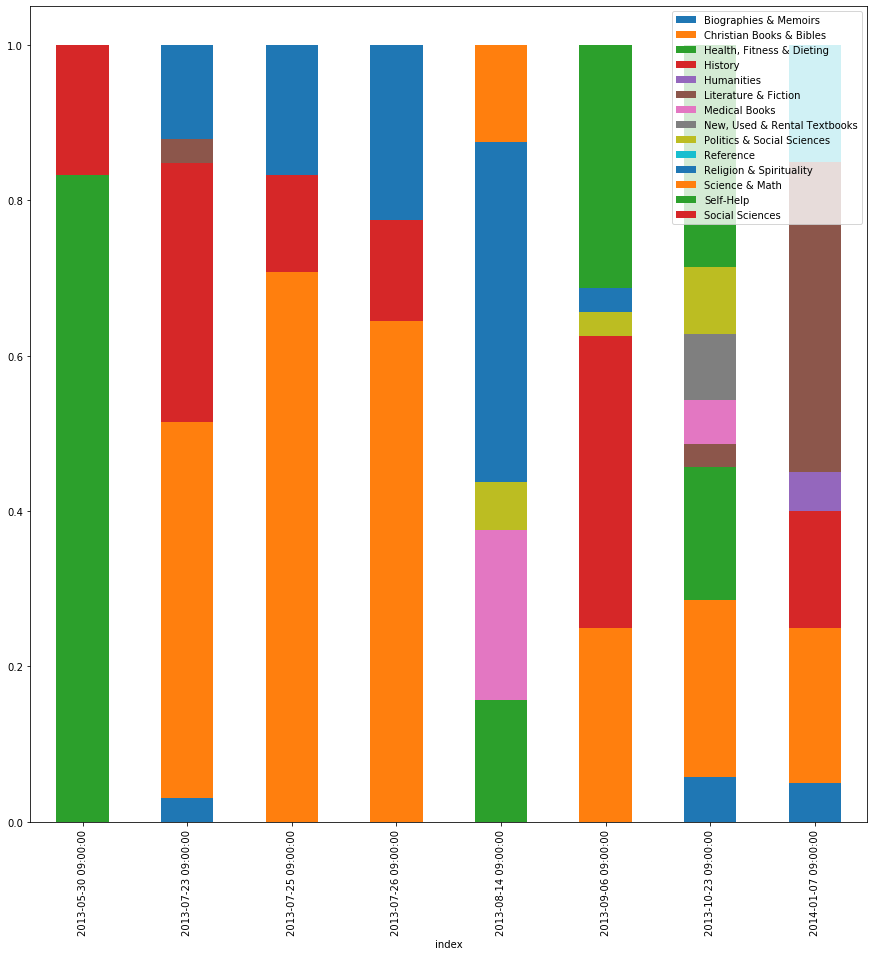

In [119]:
b.plot.bar(figsize = (15,15), width = 0.5, stacked=True, tick_label = True)

In [ ]:
mxusr_count.plot.bar(figsize = (10,20), 
    stacked = True, 
    title = 'Stacked Bar Graph', 
    mark_right = True) 

In [ ]:
# category가 비어있는 데이터는 어떡하징?